In [1]:
pip install pyspark

# Importing packages to create spark session

In [2]:
import pandas as pd
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('model').getOrCreate()

In [4]:
spark

# Reading Data

In [5]:
df = spark.read.csv('/content/housing.csv', header= True , inferSchema =True)

In [6]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [7]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [8]:
df.count()

20640

# Using aggrigation functions

In [9]:
from pyspark.sql.functions import mean
df.select([mean(c) for c in df.columns]).show()

+-------------------+----------------+-----------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------------+--------------------+
|     avg(longitude)|   avg(latitude)|avg(housing_median_age)|  avg(total_rooms)|avg(total_bedrooms)|   avg(population)|  avg(households)|avg(median_income)|avg(median_house_value)|avg(ocean_proximity)|
+-------------------+----------------+-----------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------------+--------------------+
|-119.56970445736148|35.6318614341087|     28.639486434108527|2635.7630813953488|  537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|     206855.81690891474|                null|
+-------------------+----------------+-----------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------------+-------

In [10]:
df.groupby('ocean_proximity').mean().show()

+---------------+-------------------+------------------+-----------------------+------------------+-------------------+------------------+------------------+------------------+-----------------------+
|ocean_proximity|     avg(longitude)|     avg(latitude)|avg(housing_median_age)|  avg(total_rooms)|avg(total_bedrooms)|   avg(population)|   avg(households)|avg(median_income)|avg(median_house_value)|
+---------------+-------------------+------------------+-----------------------+------------------+-------------------+------------------+------------------+------------------+-----------------------+
|         ISLAND|           -118.354|33.358000000000004|                   42.4|            1574.6|              420.4|             668.0|             276.6|2.7444200000000003|               380440.0|
|     NEAR OCEAN|-119.33255455229478| 34.73843867569602|     29.347253574115875| 2583.700902934537|  538.6156773211568|1354.0086531226486|501.24454477050415| 4.005784800601957|     249433.97742663

In [12]:
continous_features = df.columns[:-2]
continous_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [13]:
categorical_features = ['ocean_proximity']

# Imputing Missing Values

In [14]:
from pyspark.ml.feature import Imputer
imputer  = Imputer(inputCols = continous_features , outputCols = continous_features).setStrategy('mean')

In [15]:
df = imputer.fit(df).transform(df)

In [16]:
panda_df = df.toPandas()

In [17]:
panda_df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [18]:
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

# Assembling input features together

In [19]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols= continous_features , outputCol= 'continous_feature_vec')
df = assembler.transform(df)
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|continous_feature_vec|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY| [-122.23,37.88,41...|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY| [-122.22,37.86,21...|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY| [-122.24,37.85,52...|
|  -122.25|   37.85|              52.0| 

# Standardizing input data

In [20]:
from pyspark.ml.feature import StandardScaler
ss = StandardScaler(inputCol='continous_feature_vec',outputCol = 'scaled_contionus_feature_vec',withStd=True , withMean=True)
df = ss.fit(df).transform(df)
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+----------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|continous_feature_vec|scaled_contionus_feature_vec|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+----------------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY| [-122.23,37.88,41...|        [-1.3278030546902...|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY| [-122.22,37.86,21...|        [-1.3228118684350...|
|  -122.24|   37.85|              52.0|     1467.0|    

# Encoding categorical columns to one hot encoded vector

In [21]:
from pyspark.ml.feature import StringIndexer
si = StringIndexer(inputCol = 'ocean_proximity',outputCol = 'indexed_ocean_proximity')
df = si.fit(df).transform(df)
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+----------------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|continous_feature_vec|scaled_contionus_feature_vec|indexed_ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+----------------------------+-----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY| [-122.23,37.88,41...|        [-1.3278030546902...|                    3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY| [-122.22,3

In [22]:
from pyspark.ml.feature import OneHotEncoder
ohe = OneHotEncoder(inputCol='indexed_ocean_proximity',outputCol = 'ocean_proximity_vec')
df = ohe.fit(df).transform(df)
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+----------------------------+-----------------------+-------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|continous_feature_vec|scaled_contionus_feature_vec|indexed_ocean_proximity|ocean_proximity_vec|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------------+----------------------------+-----------------------+-------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY| [-122.23,37.88,41...|        [-1.3278030546902...|                    3.0|      (4,[3],[1.0])|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|  

In [23]:
final_df = df.select(['scaled_contionus_feature_vec','ocean_proximity_vec','median_house_value'])
final_df.show()

+----------------------------+-------------------+------------------+
|scaled_contionus_feature_vec|ocean_proximity_vec|median_house_value|
+----------------------------+-------------------+------------------+
|        [-1.3278030546902...|      (4,[3],[1.0])|          452600.0|
|        [-1.3228118684350...|      (4,[3],[1.0])|          358500.0|
|        [-1.3327942409452...|      (4,[3],[1.0])|          352100.0|
|        [-1.3377854272003...|      (4,[3],[1.0])|          341300.0|
|        [-1.3377854272003...|      (4,[3],[1.0])|          342200.0|
|        [-1.3377854272003...|      (4,[3],[1.0])|          269700.0|
|        [-1.3377854272003...|      (4,[3],[1.0])|          299200.0|
|        [-1.3377854272003...|      (4,[3],[1.0])|          241400.0|
|        [-1.3427766134554...|      (4,[3],[1.0])|          226700.0|
|        [-1.3377854272003...|      (4,[3],[1.0])|          261100.0|
|        [-1.3427766134554...|      (4,[3],[1.0])|          281500.0|
|        [-1.3427766

In [24]:
vector_assembler = VectorAssembler(inputCols=final_df.columns[:2],outputCol = 'independent_feature')
final_df = vector_assembler.transform(final_df)

# Preparing final data for model building

In [25]:
final_df = final_df.select(['independent_feature','median_house_value'])
final_df.show()

+--------------------+------------------+
| independent_feature|median_house_value|
+--------------------+------------------+
|[-1.3278030546902...|          452600.0|
|[-1.3228118684350...|          358500.0|
|[-1.3327942409452...|          352100.0|
|[-1.3377854272003...|          341300.0|
|[-1.3377854272003...|          342200.0|
|[-1.3377854272003...|          269700.0|
|[-1.3377854272003...|          299200.0|
|[-1.3377854272003...|          241400.0|
|[-1.3427766134554...|          226700.0|
|[-1.3377854272003...|          261100.0|
|[-1.3427766134554...|          281500.0|
|[-1.3427766134554...|          241800.0|
|[-1.3427766134554...|          213500.0|
|[-1.3427766134554...|          191300.0|
|[-1.3427766134554...|          159200.0|
|[-1.3427766134554...|          140000.0|
|[-1.3477677997105...|          152500.0|
|[-1.3477677997105...|          155500.0|
|[-1.3427766134554...|          158700.0|
|[-1.3477677997105...|          162900.0|
+--------------------+------------

In [26]:
final_df.select('independent_feature').take(2)

[Row(independent_feature=DenseVector([-1.3278, 1.0525, 0.9821, -0.8048, -0.9752, -0.9744, -0.977, 2.3447, 0.0, 0.0, 0.0, 1.0])),
 Row(independent_feature=DenseVector([-1.3228, 1.0432, -0.607, 2.0458, 1.3551, 0.8614, 1.6699, 2.3322, 0.0, 0.0, 0.0, 1.0]))]

# Splitting data to train and test

In [27]:
train_data , test_data = final_df.randomSplit([0.7,0.3] , seed =42)

In [28]:
train_data.show()

+--------------------+------------------+
| independent_feature|median_house_value|
+--------------------+------------------+
|[-2.3859345407710...|           94600.0|
|[-2.3609786094955...|           85800.0|
|[-2.3460050507303...|           79000.0|
|[-2.3410138644752...|          111400.0|
|[-2.3360226782201...|           76100.0|
|[-2.3260403057099...|           50800.0|
|[-2.3160579331997...|           58100.0|
|[-2.3160579331997...|           66900.0|
|[-2.3160579331997...|           68400.0|
|[-2.3060755606895...|           74600.0|
|[-2.3010843744344...|          107000.0|
|[-2.3010843744344...|           72200.0|
|[-2.3010843744344...|           70200.0|
|[-2.3010843744344...|           64600.0|
|[-2.2960931881793...|          116100.0|
|[-2.2960931881793...|           82800.0|
|[-2.2960931881793...|           81300.0|
|[-2.2960931881793...|           62500.0|
|[-2.2960931881793...|          105900.0|
|[-2.2911020019242...|           85600.0|
+--------------------+------------

# Building regression model

In [29]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'independent_feature',labelCol = 'median_house_value')
lr

LinearRegression_2ca3784a00e6

In [30]:
lr = lr.fit(train_data)

In [31]:
lr.intercept

368413.9308259478

In [32]:
lr.coefficients

DenseVector([-53073.6599, -54566.2133, 13071.5796, -5751.407, 26902.7558, -52672.4223, 35003.55, 72152.5509, -149114.1152, -189326.197, -143950.3796, -153428.6234])

In [33]:
train_prediction = lr.evaluate(train_data)

In [34]:
train_prediction

In [35]:
test_prediction = lr.evaluate(test_data)

In [36]:
train_prediction.predictions.show(5)

+--------------------+------------------+------------------+
| independent_feature|median_house_value|        prediction|
+--------------------+------------------+------------------+
|[-2.3859345407710...|           94600.0|212146.86436678658|
|[-2.3609786094955...|           85800.0|115134.71629759666|
|[-2.3460050507303...|           79000.0|183751.79074905955|
|[-2.3410138644752...|          111400.0|193117.31133886985|
|[-2.3360226782201...|           76100.0|172983.85126571616|
+--------------------+------------------+------------------+
only showing top 5 rows



In [37]:
test_prediction.predictions.show(5)

+--------------------+------------------+------------------+
| independent_feature|median_house_value|        prediction|
+--------------------+------------------+------------------+
|[-2.3609786094955...|          103600.0|151110.67697918246|
|[-2.3260403057099...|          106700.0| 217997.4906547826|
|[-2.3260403057099...|           73200.0| 126089.7752789314|
|[-2.3210491194548...|           78300.0|127464.02999358327|
|[-2.3060755606895...|           90100.0|195513.64035668658|
+--------------------+------------------+------------------+
only showing top 5 rows



# Model Evaluation

Evalutation of training data

In [38]:
train_prediction.r2

0.6452128121552176

In [39]:
train_prediction.meanAbsoluteError

49629.86327933735

In [40]:
train_prediction.r2adj

0.644919114152035

In [41]:
train_prediction.meanSquaredError

4693932219.536894

Evaluation of test data

In [42]:
test_prediction.r2

0.6427231574733281

In [43]:
test_prediction.meanAbsoluteError

50454.17906005325

In [44]:
test_prediction.r2adj

0.6420223856344396

In [45]:
test_prediction.meanSquaredError

4824753179.40055

# Plotting actual vs prediction label for test data

In [46]:
test_prediction_pandas = train_prediction.predictions.toPandas()

In [47]:
test_prediction_pandas.head()

,independent_feature,median_house_value,prediction
0,"[-2.3859345407710877, 2.2978688905870066, 1.85...",94600.0,212146.864367
1,"[-2.3609786094955965, 2.887769677467864, -0.76...",85800.0,115134.716298
2,"[-2.3460050507303, 2.368095174739489, 0.584838...",79000.0,183751.790749
3,"[-2.341013864475206, 2.316595899694335, 1.8561...",111400.0,193117.311339
4,"[-2.336022678220105, 2.17614333138937, 0.26701...",76100.0,172983.851266


In [48]:
import matplotlib.pyplot as plt

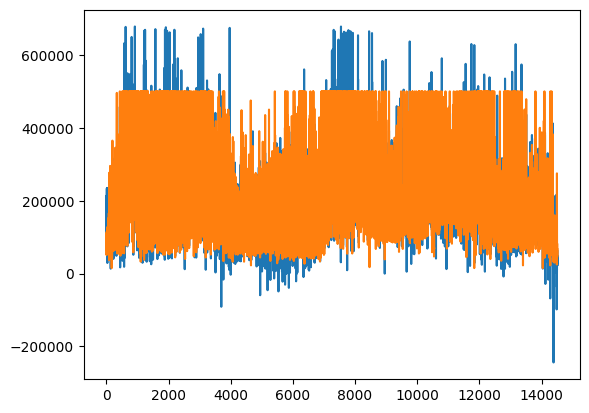

In [49]:
plt.plot(test_prediction_pandas['prediction'])
plt.plot(test_prediction_pandas['median_house_value'])
plt.show()

# Saving Model

In [57]:
lr.save('/content/model')

In [55]:
pwd

'/content'